# GP optimizer for one single hexapole

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/cz489/STEMalign_BO/GPTrelated')
saveResultsQ = False
import scipy

failed to import parallelstuff


### Creat the machine interface

In [28]:
ndim = 1 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
start_point = [[4.9]]  # use H1 = H2 = 25 as default start, following Cameron's setup
#min-max range

#creat machine interface
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
# mi_module = importlib.import_module('multinormal')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
# assuming an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background 
# noise with std dev = 0.1

In [29]:
mi.x[0]

array([4.9])

In [30]:
#check the reading objective is working
mi.getState()

/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([[4.9]]), array([[-1265939.67620844]]))

In [88]:
#check noise std
y = [mi.getState()[1][0] for x in range(5)]
np.std(y)

0.0

### Create the gp

In [31]:
gp_ls = np.array(np.ones(ndim))
gp_amp = 3e6 # default = 1
gp_noise = 0.0  # default = 0.001

gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

gp = OGP(ndim, hyps,prmean=0)

/nfs/user/cz489/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


### Create the BO

In [32]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = np.array([2, None])

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f99f9ddfe10>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[4.9]]
y_init [[-1265939.67620844]]
Using prior mean function of  0
Using prior mean parameters of  None


**Running BO**

*run the gp search for some number of steps*

In [33]:
Obj_state_s=[]

In [34]:
Niter = 8
for i in range(Niter):
    
    print ('iteration =', i)
   
    Obj_state_s.append(mi.getState()[1][0])
    print ('current position:', mi.x, 'current objective value:', Obj_state_s[-0])
    
#     f = plt.figure(figsize=(20,3))
#     ax = f.add_subplot(121)
#     ax2 = f.add_subplot(122)
#     ax.set_ylabel('Input controls',fontsize=12)
#     ax.set_xlabel('Step',fontsize=12)    
#     ax.plot(opt.X_obs)
#     ax2.set_ylabel('Objective',fontsize=12)
#     ax2.set_xlabel('Step',fontsize=12)
#     ax2.plot(Obj_state_s)
#     plt.show(); 
    
    
    # copy the generated ronchigram file to result folder, use them as a reference for tuning 
    ronch_file = "/home/cz489/STEMalign_BO/SimulationResults/ronchigram_iter" + str(i) + ".npy"
    png_file = "/home/cz489/STEMalign_BO/SimulationResults/GPstatus_iter" + str(i) + ".png"
    os.rename("/home/cz489/STEMalign_BO/ronchigram.npy", ronch_file)
    
    x = np.linspace(-10,10,100)
    y = x*0
    yval = x*0
    yerr = x*0
    for i in range(len(x)):
        y[i] = negUCB(x[i],opt.model, 1, 0)
        yval[i] = opt.model.predict(np.array([x[i]],ndmin=2))[0][0]
        yerr[i] = opt.model.predict(np.array([x[i]],ndmin=2))[1][0]
        
    fig = plt.figure(figsize=(20,5))
    
    plt.subplot(121)
    plt.errorbar(x,-yval,yerr = yerr, label = 'Mean Prediction')
    plt.plot(hex_list, -np.asarray(emit_list), linewidth = '3', label = 'Truth')
    plt.ylabel('Emittance^2',fontsize = 16)
    plt.xlabel('H1 current',fontsize  = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize = 16)

    plt.subplot(122)
    plt.plot(x,y)
#     plt.axvline(x=mi.x,linewidth = 2,c='r')
    plt.ylabel('Acquisition Func',fontsize = 16)
    plt.xlabel('H1 current',fontsize  = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.show()
    fig.savefig(png_file)
    clear_output(wait=True) 
    
    opt.OptIter()

[-0.24430975] [[-79223.15159799]]
[-0.24430975]
single-processing, minimize, x_start = [-0.24430975]
Minimizing finished, min point = [-0.27808699]
New State: [[-0.27808699]], [[-80211.25173085]]


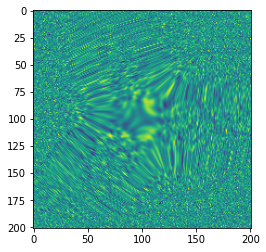

In [27]:
temp = np.load('SimulationResults/ronchigram_iter0.npy')
plt.imshow(temp)

## Test behavior of the negative UCB function and scipy.optimize.minimize

In [39]:
print('negUCB = ' + str(negUCB(4.0, opt.model, 1, 0)))
print(opt.model.predict(np.array([5.000],ndmin=2)))

negUCB = 663766.8124901754
(array([[-1080878.45850926]]), array([[362.97539488]]))


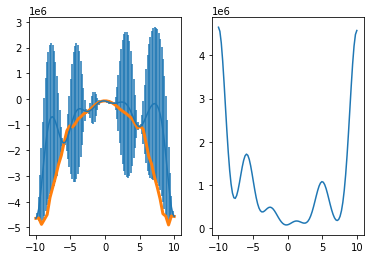

In [40]:
x = np.linspace(-10,10,100)
y = x*0
yval = x*0
yerr = x*0
for i in range(len(x)):
    y[i] = negUCB(x[i],opt.model, 1, 0)
    yval[i] = opt.model.predict(np.array([x[i]],ndmin=2))[0][0]
    yerr[i] = opt.model.predict(np.array([x[i]],ndmin=2))[1][0]
plt.subplot(121)
plt.errorbar(x,yval,yerr = yerr)
plt.plot(hex_list, np.asarray(emit_list), linewidth = '3')

plt.subplot(122)
plt.plot(x,y)

In [17]:
opt.model.predict(np.array([4.9],ndmin=2))

(array([[-1110698.93832676]]), array([[19506.25345827]]))

In [20]:
bnds = [(-10, 10)]
x0 = 5
ndim = 1
nsteps = 1
nu = 2
delta = None
res = scipy.optimize.minimize(negUCB, x0, args=(opt.model, ndim, nsteps, nu, delta), 
                              method='L-BFGS-B',tol=1e-4,bounds=bnds,options={'maxiter':1000})     
print(res.x)

[10.]


## Scan Test
Test a series of different values for the hexapoles to determine the noise and magnitute that should be used for the GP.
<br>The calculated emittance vs hexpole current can also be used as a reference for the real objective function during the GP test.

In [17]:
# 1D scan along hex1 = hex2
ndim = 1 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
hex_list = np.linspace(-10,10,num=50)
emit_list = []

for i in range(len(hex_list)):
    start_point = [[hex_list[i]]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_list.append(mi.getState()[1][0])
    print(hex_list[i], emit_list[-1])

/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-10.0 [-6010044.18388522]
-9.591836734693878 [-5803943.05283824]
-9.183673469387756 [-5274068.99946493]
-8.775510204081632 [-4800190.24478108]
-8.36734693877551 [-4065848.67821741]
-7.959183673469388 [-3501068.55207373]
-7.551020408163265 [-3046295.96552797]
-7.142857142857142 [-2554342.6279606]
-6.73469387755102 [-2173358.50183937]
-6.326530612244898 [-1632784.74492598]
-5.918367346938775 [-1558851.76021485]
-5.5102040816326525 [-1408022.94394324]
-5.1020408163265305 [-1339410.76974713]
-4.6938775510204085 [-1146042.58202574]
-4.285714285714286 [-958220.81320743]
-3.8775510204081627 [-939958.14012719]
-3.4693877551020407 [-754303.25934222]
-3.0612244897959187 [-666921.00135978]
-2.6530612244897958 [-550083.11045413]
-2.244897959183673 [-439612.63489431]
-1.8367346938775508 [-307188.53196098]
-1.4285714285714288 [-209582.38070512]
-1.020408163265305 [-143353.41252595]
-0.612244897959183 [-97976.42496676]
-0.204081632653061 [-77537.29619652]
0.204081632653061 [-77609.35824669]
0.6122448

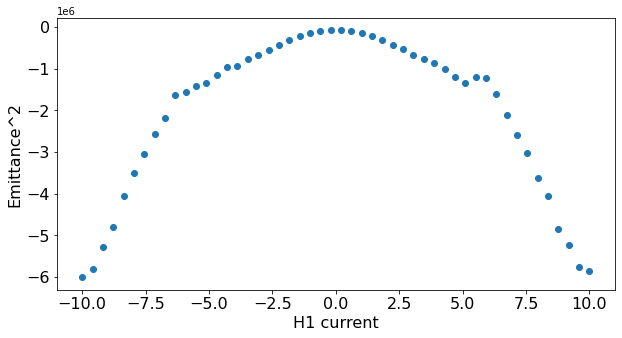

In [18]:
fig = plt.figure(figsize = [10,5])
plt.scatter(hex_list, np.asarray(emit_list))
plt.ylabel('Emittance^2',fontsize = 16)
plt.xlabel('H1 current',fontsize  = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('hex_scan_h1=-100_100_h2=8.png')

np.save('emit_list_ref_H1=-10_10_100steps.npy',np.asarray(emit_list))
np.save('hex_list_ref_H1=-10_10_100steps.npy',hex_list)

In [9]:
hex_list = np.load("hex_list_ref_H1=-10_10_100steps.npy")
emit_list = np.load("emit_list_ref_H1=-10_10_100steps.npy")

44.0 -100.0 12059988.672165059


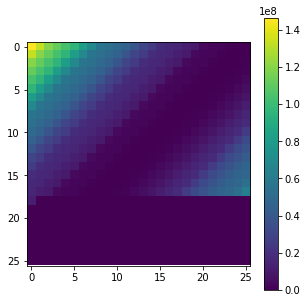

In [ ]:
# 2D parameter scan for all (hex1, hex2) pairs
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
hex_list = np.linspace(-100,100,num=26)
emit_matrix = np.zeros([26,26])

for i in range(len(hex_list)):
    for j in range(len(hex_list)):
        imgname = '/home/cz489/STEMalign_BO/SimulationResults/ronchigram_'+ str(i)+'_'+str(j)+'.npy'
        txtname = '/home/cz489/STEMalign_BO/SimulationResults/outscope_'+ str(i)+'_'+str(j)+'.txt'
        if os.path.exists(txtname):
            emit_matrix[i,j] = calcEmittance(txtname)
        else:
            start_point = [hex_list[i],hex_list[j]]  # use H1 = H2 = 25 as default start, following Cameron's setup
            mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
            mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
            emit_matrix[i,j] = mi.getState()[1][0]
            
#             os.rename("/home/cz489/STEMalign_BO/outscope.txt", txtname)
#             os.rename("/home/cz489/STEMalign_BO/ronchigram.npy", imgname)
        
        clear_output(wait=True)
        print(hex_list[i], hex_list[j], emit_matrix[i,j])
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix)
        plt.colorbar()
        plt.show()


            

In [3]:
start_point = [36,-44]  # use H1 = H2 = 25 as default start, following Cameron's setup
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
print(mi.getState())

(array([[ 36, -44]]), array([[3297512.23044574]]))


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
def negUCB(x_new, model, ndim, nsteps, nu = 1., delta = 1.):
    """
    GPUCB: Gaussian process upper confidence bound aquisition function
    Default nu and delta hyperparameters theoretically yield "least regret".
    Works better than "expected improvement" (for alpha==1 above) in 2D.

    input params
    x_new: new point in the dim-dimensional space the GP is fitting
    model: OnlineGP object
    ndim: feature space dimensionality (how many devices are varied)
    nsteps: current step number counting from 1
    nu: nu in the tutorial (see above)
    delta: delta in the tutorial (see above)
    """

    if nsteps==0: nsteps += 1
    (y_mean, y_var) = model.predict(np.array(x_new,ndmin=2))

    if delta is None:
        GPUCB = y_mean + nu * np.sqrt(y_var)
    else:
        tau = 2.*np.log(nsteps**(0.5*ndim+2.)*(np.pi**2.)/3./delta)
        GPUCB = y_mean + np.sqrt(nu * tau * y_var)
    GPUCB = np.squeeze(GPUCB)

    return -GPUCB